In [100]:
import json
import gzip
from itertools import islice
from collections import Counter, defaultdict
from operator import itemgetter
from sklearn.preprocessing import OneHotEncoder
# importing MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

import pandas as pd
from tqdm.notebook import tqdm

In [101]:
def read_vacancies_part(part):
    with gzip.open(f'/content/drive/My Drive/hh/vacancies-{part:02}.json.gz', 'r') as fp:
        return json.loads(fp.read())

In [102]:
%%time

part = read_vacancies_part(1)
print(f'Всего вакансий в части 1: {len(part):,d}')

Всего вакансий в части 1: 300,000
CPU times: user 10.7 s, sys: 1.52 s, total: 12.2 s
Wall time: 12.3 s


In [103]:
df = pd.DataFrame.from_dict(part, orient='index')

In [104]:
df['vacancy_id'] = range(1, len(df) + 1)
df = df.drop(['area_id','creation_date', 'employment', 'currency', 'compensation_to', 'compensation_from', 'work_schedule', 'work_experience', 'employer'], axis=1)

In [105]:
df.head()

,name,description,key_skills,vacancy_id
1,Администратор торгового зала,<strong>Обязанности:</strong> <ul> <li>Админис...,[],1
2,Супервайзер команды Службы поддержки пользоват...,"<p>В связи с расширением, в международной комп...",[],2
3,Системный администратор,<p>Для обеспечения технической поддержки объек...,[],3
4,Специалист по закупкам,<strong>Обязанности:</strong> <ul> <li>Организ...,"[Деловая переписка, Заключение договоров, Дело...",4
5,Уборщик помещений / Уборщица,<p>Ресторан O.D.I. приглашает на работу Уборщи...,[],5


Загрузим данные тренировочные данные с верными специализациями. Добавим converters={'specializations': eval} для того чтобы pandas сохранил данные по специализвациям как список.

In [106]:
df.description = df.description.str.replace(r'\<[^\>]*\>', ' ')
df.description = df.description.str.lower()
df.description = df.description.str.replace(r"[0-9]", ' ')
df.description = df.description.str.replace(r"\s+[а-я]\s+", ' ')
df.description = df.description.str.replace(r'\s+', ' ')
df.description[8]


' обязанности: ремонт техническое обслуживание легковых автомобилей соблюдение сроков качества ремонта требования: опыт ремонта обслуживания легковых автомобилей отличное знание устройства автомобиля ответственность исполнительность техническая грамотность условия: график работы сменный : / ( воскресенье выходной) : до : своевременная зарплата ( выдается после рабочего дня каждый день) '

In [107]:
train_specializations = pd.read_csv('/content/drive/My Drive/hh/train_labels.csv',converters={'specializations': eval})

In [108]:
df_test = pd.read_csv('/content/drive/My Drive/hh/test_vacancy_ids.csv')
test = pd.merge(df, df_test, on='vacancy_id', how='inner')
train = pd.merge(df, train_specializations, on='vacancy_id', how='inner')
test.head()

,name,description,key_skills,vacancy_id
0,Супервайзер команды Службы поддержки пользоват...,"связи расширением, международной компании olx...",[],2
1,Уборщик помещений / Уборщица,ресторан o.d.i. приглашает на работу уборщика...,[],5
2,Грузчик в Отдел Доставок,фабрика корпусной мебели примет на работу гру...,"[Грузчики, Доставка мебели]",7
3,Прораб (фасадные работы),должностные обязанности: - руководство бригад...,[],8
4,Administrative assistant,responsibilities: maintaining the condition o...,"[Английский язык, Project management, MS Acces...",10


In [109]:
train.head()

,name,description,key_skills,vacancy_id,specializations
0,Администратор торгового зала,обязанности: администратор торгового зала кон...,[],1,"[242, 256, 302, 324, 358, 440]"
1,Системный администратор,для обеспечения технической поддержки объекто...,[],3,[211]
2,Специалист по закупкам,обязанности: организация проведение закупок р...,"[Деловая переписка, Заключение договоров, Дело...",4,"[389, 412, 437]"
3,Ведущий инженер,обязанности: взаимодействие рсо части ответов...,[],6,[445]
4,Автомеханик /Автослесарь (Моторист),обязанности: ремонт техническое обслуживание ...,[],9,[503]


# Обработка текста

Убираем html теги

In [110]:
list_sentences_train =  train.description.values
list_sentences_test = test.description.values

# Токенизация текста

Необходимые импорты


In [111]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [112]:
maxlen = 250

In [113]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [114]:
totalNumWords = [len(one_descr) for one_descr in list_tokenized_train]

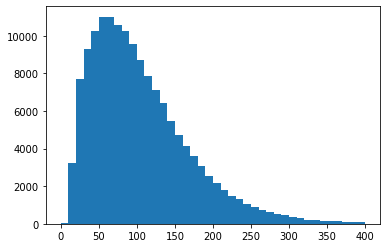

In [115]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

# Labes

In [116]:
# instantiating MultiLabelBinarizer
mlb = MultiLabelBinarizer()


In [117]:
data = train['specializations'].tolist()

In [118]:
y = pd.DataFrame(mlb.fit_transform(data), columns=mlb.classes_).values
y

(149932, 614)

In [119]:
len(mlb.classes_)

614

#Создадим нейросеть






In [120]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [130]:
def get_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(len(mlb.classes_), activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


model = get_model()
batch_size = 5000
epochs = 3

In [122]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 300, 128)          1280000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 300, 100)          71600     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 100)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0   

In [123]:
X_t.shape

(149932, 300)

In [124]:
file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [checkpoint, early] #early

In [131]:
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

y_test = model.predict(X_te)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 134938 samples, validate on 14994 samples
Epoch 1/3
134938/134938 [==============================] - 69s 513us/step - loss: 0.5663 - accuracy: 0.8555 - val_loss: 0.2313 - val_accuracy: 0.9933

Epoch 00001: val_loss did not improve from 0.02934
Epoch 2/3
134938/134938 [==============================] - 68s 505us/step - loss: 0.0751 - accuracy: 0.9947 - val_loss: 0.0339 - val_accuracy: 0.9950

Epoch 00002: val_loss did not improve from 0.02934
Epoch 3/3
134938/134938 [==============================] - 68s 503us/step - loss: 0.0326 - accuracy: 0.9950 - val_loss: 0.0301 - val_accuracy: 0.9950

Epoch 00003: val_loss did not improve from 0.02934


In [137]:
y_test[1]

array([1.43105444e-03, 1.10827456e-03, 1.83528848e-03, 2.57302861e-04,
       5.29259967e-04, 1.05570978e-03, 3.74360156e-04, 1.03214970e-02,
       2.69785011e-03, 1.16853812e-03, 8.53974430e-04, 7.63579970e-04,
       1.32640242e-03, 2.21684552e-03, 2.70399079e-03, 1.51238521e-03,
       2.40890011e-02, 1.34171185e-03, 1.02945569e-03, 1.78442546e-03,
       2.43651238e-03, 7.40818970e-04, 3.01247550e-04, 2.94038211e-03,
       4.40979516e-03, 2.38742400e-03, 1.55672873e-03, 5.57159190e-04,
       1.09126384e-03, 6.37859281e-04, 2.26190384e-03, 6.45305379e-04,
       7.80758739e-04, 9.32282826e-04, 2.48303125e-03, 2.65601790e-04,
       9.08526126e-04, 7.69256672e-04, 1.95846497e-03, 5.08933142e-03,
       6.15053461e-04, 8.00758041e-03, 4.59942296e-02, 2.80344533e-03,
       5.22019574e-04, 5.17534092e-04, 5.98183833e-03, 3.76982556e-04,
       9.00236890e-04, 1.70839194e-03, 8.91991134e-04, 1.63579138e-03,
       1.21056254e-03, 6.27223286e-04, 1.28925522e-03, 4.06290288e-04,
      

In [133]:
predictions = np.argmax(y_test, axis=1)


In [135]:
predictions[:150]

array([148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       254, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       254, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       148, 148, 148, 148, 148, 148, 148, 148, 148, 254, 148, 148, 148,
       148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       148, 148, 148, 148, 148, 254, 148, 148, 148, 148, 148, 148, 148,
       148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
       148, 148, 148, 148, 148, 148, 148])